In [1]:
# UPORABNO:
# Povezava: https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

In [4]:
## knjižnice:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

In [6]:
## podatki, ki so nam jih poslali:
podatki = pd.read_csv(os.path.join('C:/Users/Uporabnik/OneDrive/Namizje/SOLA/MAGISTERIJ/MATEMATIKA Z RACUNALNIKOM/GospodinjskiOdjemalci.csv'), sep=";")
# Malo boljši format:
podatki['DateTimeStartUTC'] = pd.to_datetime(podatki['DateTimeStartUTC'], format='%d.%m.%Y %H:%M')
podatki['DateTimeStartCET'] = pd.to_datetime(podatki['DateTimeStartCET'], format='%d.%m.%Y %H:%M')

podatki = podatki[['DateTimeStartUTC', 'Odjem ACT', 'Temperatura ACT', 'Temperatura FC', 'Sevanje ACT', 'Sevanje FC']]

podatki.set_index('DateTimeStartUTC', inplace=True)
podatki['Year'] = podatki.index.year
podatki['Month'] = podatki.index.month
podatki['Day'] = podatki.index.date

podatki = podatki.asfreq('15T')

podatki['Odjem ACT'] = podatki['Odjem ACT'] * 1000000000 # da dobim MWh (bo lepše pri logaritmu tega stolpce v nadaljevanju)

podatki

,Odjem ACT,Temperatura ACT,Temperatura FC,Sevanje ACT,Sevanje FC,Year,Month,Day
DateTimeStartUTC,,,,,,,,
2021-10-31 23:00:00,9508.67,3.60,5.300,0.0,0.0,2021,10,2021-10-31
2021-10-31 23:15:00,9168.37,3.60,5.300,0.0,0.0,2021,10,2021-10-31
2021-10-31 23:30:00,8860.11,3.60,5.300,0.0,0.0,2021,10,2021-10-31
2021-10-31 23:45:00,8510.97,3.60,5.300,0.0,0.0,2021,10,2021-10-31
2021-11-01 00:00:00,8332.21,3.45,5.300,0.0,0.0,2021,11,2021-11-01
...,...,...,...,...,...,...,...,...
2024-02-29 21:45:00,12005.50,6.80,7.475,0.0,0.0,2024,2,2024-02-29
2024-02-29 22:00:00,11336.40,6.65,7.300,0.0,0.0,2024,2,2024-02-29
2024-02-29 22:15:00,10796.70,6.50,7.300,0.0,0.0,2024,2,2024-02-29


In [33]:
## Številki opis podatkov:
pd.DataFrame([('Odjem', podatki['Odjem ACT'].min(), podatki['Odjem ACT'].max(), podatki['Odjem ACT'].mean(), podatki['Odjem ACT'].median(), podatki['Odjem ACT'].std())],
                    columns=(' ', 'Min', 'Max', 'Povprečje', 'Mediana', 'sd' ))

,,Min,Max,Povprečje,Mediana,sd
0,Odjem,3629.32,28736.8,12240.501427,11708.45,4167.961058


In [9]:
## Vizualizacija
sns.set(rc={'figure.figsize':(20, 5)}) # sets the default figure size

<AxesSubplot: xlabel='DateTimeStartCET'>

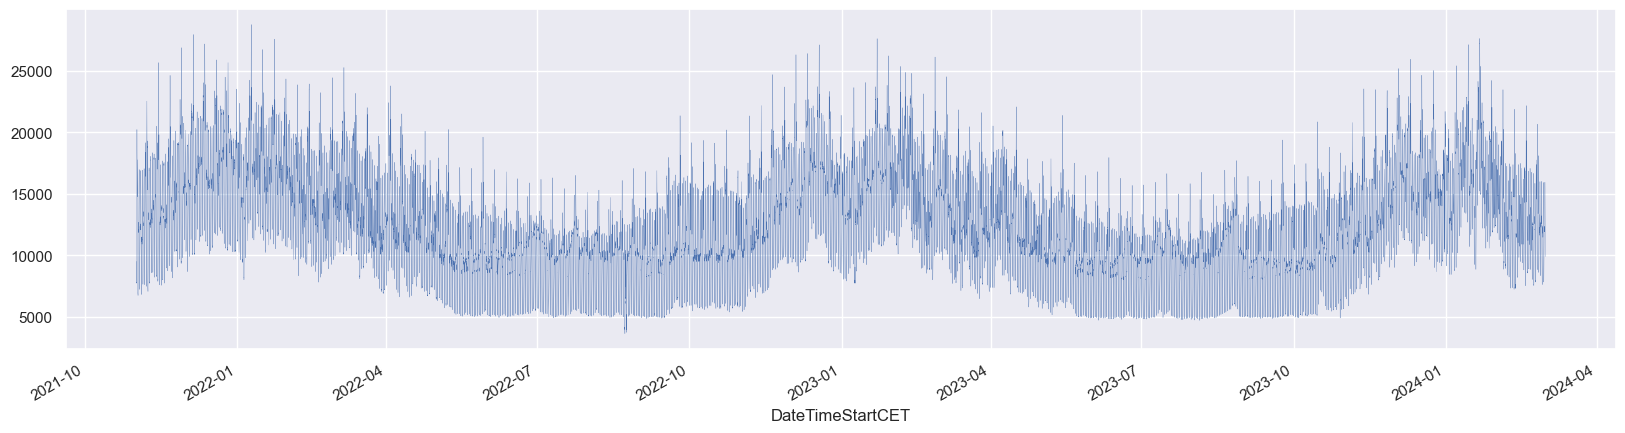

In [48]:
podatki['Odjem ACT'].plot(linewidth=0.2)

<AxesSubplot: xlabel='DateTimeStartCET'>

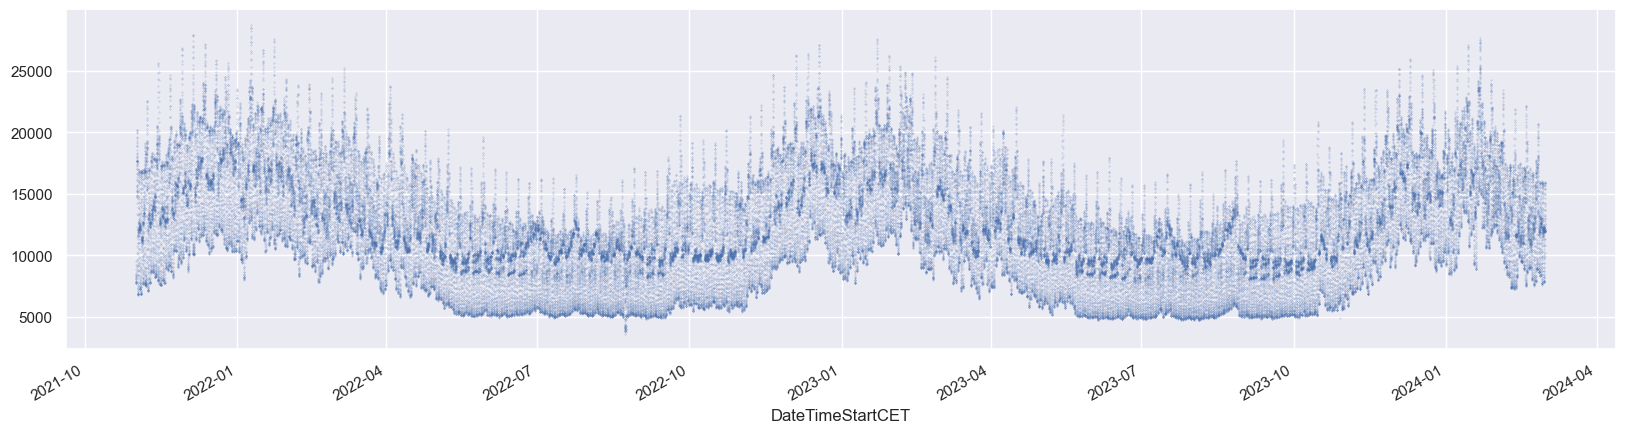

In [49]:
podatki['Odjem ACT'].plot(marker='.', alpha=0.5, linestyle='None', ms=0.5)
# iz tega grafa je malo boljše lažje razbrat stvari

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose

podatki_dec = podatki['Odjem ACT']
podatki_dec
decomp = seasonal_decompose(podatki.loc['2023', 'Odjem ACT'], model='multiplicative', period=96)
decomp.plot()

NameError: name 'podatki' is not defined

In [49]:
# opazke:
# - poraba je večja v zimskih mesecih
# - poraba se v času božičnih praznikov (konec decembra, začetek januarja) zmanjša
# - tisto kar je blizu nič predstavlja porabo tekom noči

<AxesSubplot: xlabel='DateTimeStartCET'>

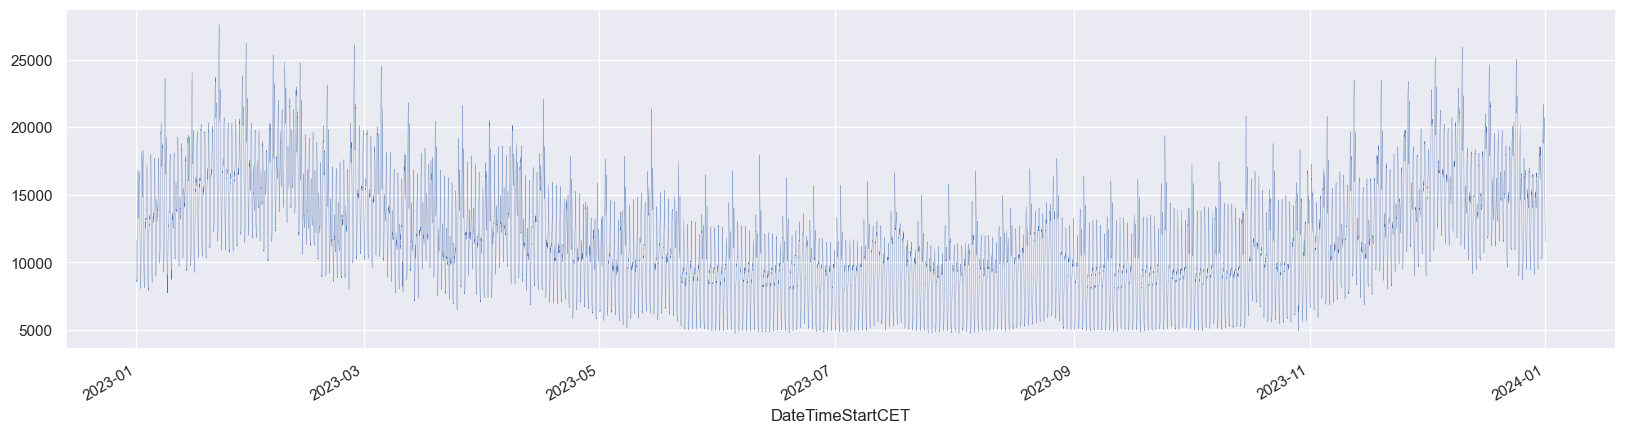

In [51]:
## odjem leta 2023:
podatki.loc['2023', 'Odjem ACT'].plot(linewidth=0.2)

In [43]:
# odjem za en teden
# podatki.loc['2022-03-01':'2022-03-07', 'Odjem ACT'].plot(marker='o', linestyle='-', linewidth=1, ms=3)

In [ ]:
## NAREDIMO ČASOVNO VRSTO STACIONARNO

# očitno je, da vrsta NI stacionarna

<AxesSubplot: xlabel='DateTimeStartUTC'>

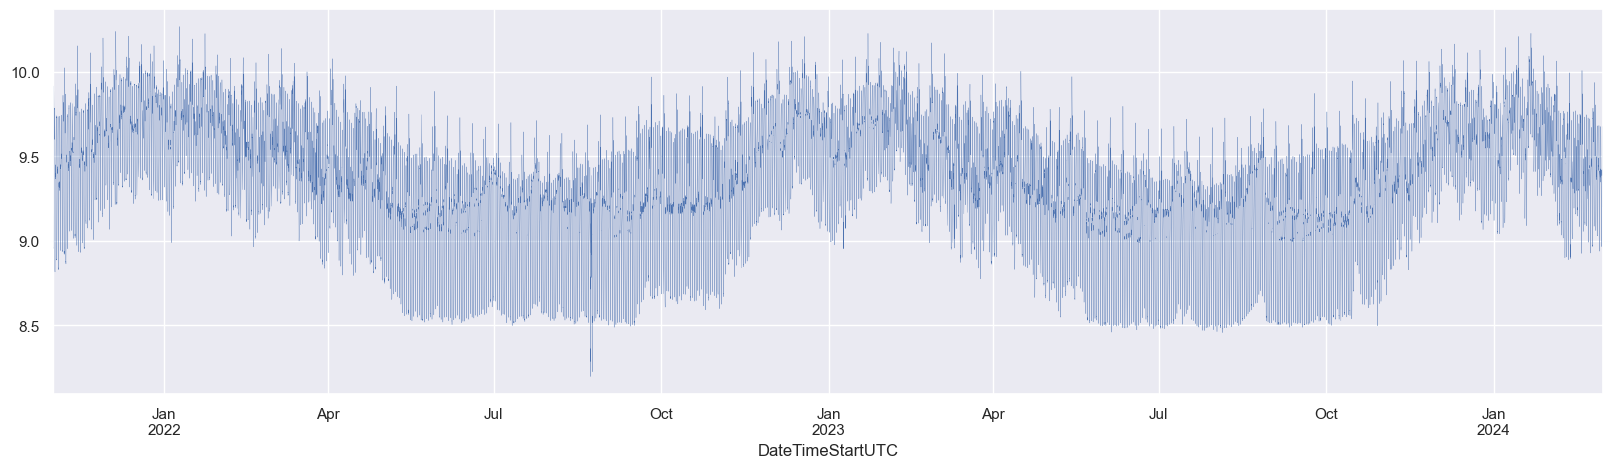

In [10]:
# Podatki so volatilni, zato najprej naredimo logaritemsko transformacijo (log(D_t)). Tako se vse malo bolj stabilizira 
podatki['Logaritem'] = np.log(podatki['Odjem ACT'])
podatki['Logaritem'].plot(linewidth=0.2)

Text(0.5, 1.0, 'Logaritem časovne vrste odjema, 2023')

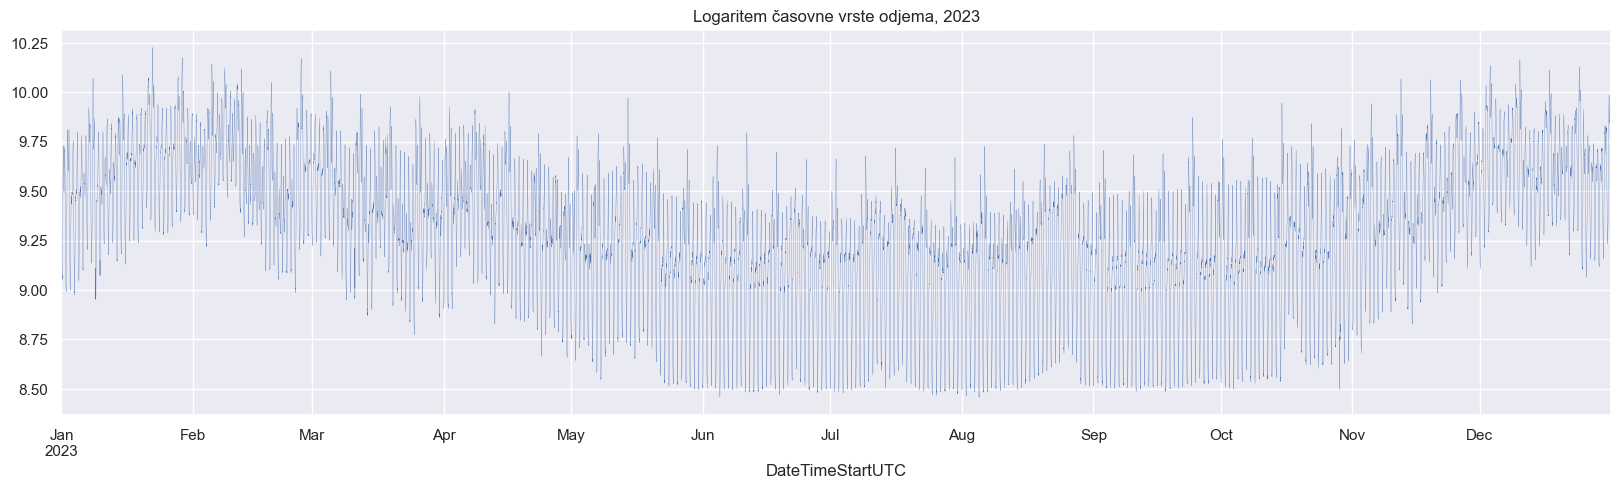

In [6]:
# zaradi velike količine podatkov, se bom osredotočala na leto 2023
podatki.loc['2023', 'Logaritem'].plot(linewidth=0.2) 
plt.title('Logaritem časovne vrste odjema, 2023')

In [57]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='BIC',regression='c')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

# The time series is considered stationary if the p-value is low (<0.05) 
#           and the Test Statistic is lower than the critical values at 1%, 5%, 10% levels of significance.

In [59]:
adf_test(podatki.loc['2023-03', 'Logaritem'].dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                -1.182224e+01
p-value                        8.361425e-22
#Lags Used                     6.000000e+00
Number of Observations Used    2.969000e+03
Critical Value (1%)           -3.432554e+00
Critical Value (5%)           -2.862514e+00
Critical Value (10%)          -2.567288e+00
dtype: float64


Text(0.5, 1.0, 'ACF na logaritmu časovne vrste, 2023')

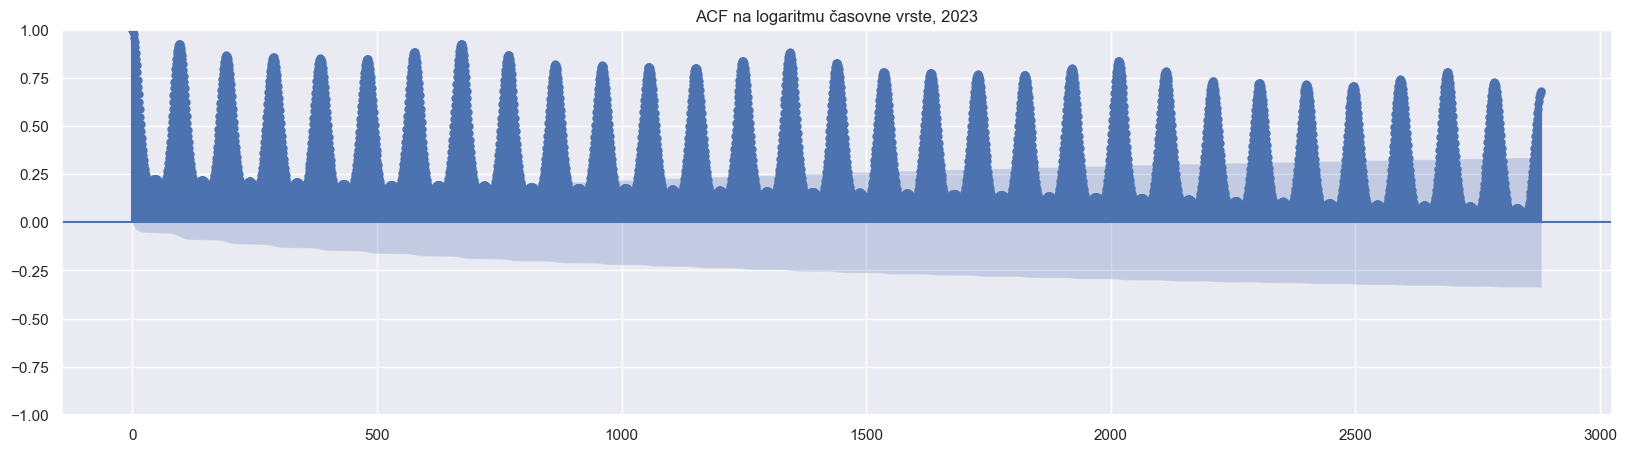

In [55]:
tsaplots.plot_acf(podatki.loc['2023', 'Logaritem'], lags=2880)
plt.ylim(-1,1)
plt.title('ACF na logaritmu časovne vrste, 2023')

# za lag sem vzela 2880, to je ravno 30 dni (96 podatkov na dan * 30 dni)

Text(0.5, 1.0, 'ACF na logaritmu časovne vrste, 2023')

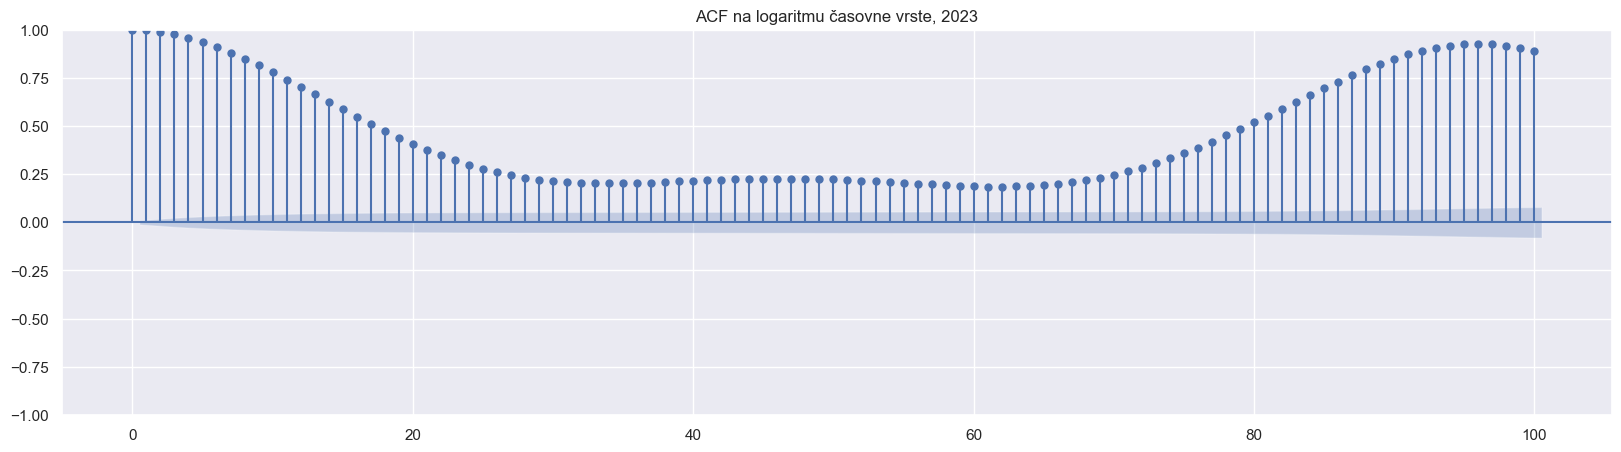

In [65]:
tsaplots.plot_acf(podatki.loc['2023', 'Logaritem'], lags=100)
plt.ylim(-1,1)
plt.title('ACF na logaritmu časovne vrste, zoženo, 2023') # -->sezonskost na vsake 96

In [94]:
# Iz ACF vidimo:
# - stacionarnosti NI
# - smiselno sezonsko komponento -> vse se ponavlja se na 1 dan (96 podatkov)

# da doseženo stacionarno poskusimo DIFERENCIRATI

Text(0.5, 1.0, 'Logaritem porabe, ki je sezonsko diferenciran s periodo 96, 2023')

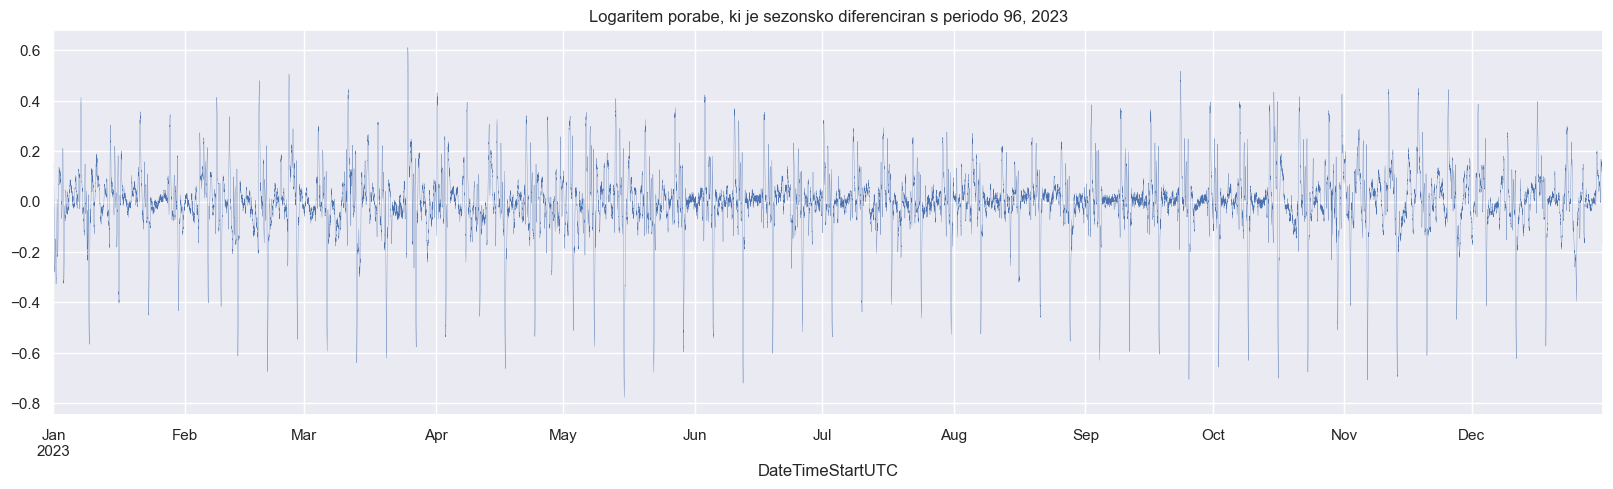

In [11]:
ts_diff = podatki['Logaritem'].diff(periods = 96)
ts_diff['2023'].plot(linewidth=0.2) 
plt.title('Logaritem porabe, ki je sezonsko diferenciran s periodo 96, 2023')

In [ ]:
# opazimo, da je časovna vrsta kar precej bolj stacionarna. Preverimo še ACF

Text(0.5, 1.0, 'ACF po prvem sezonskem diferenciranju, 2023')

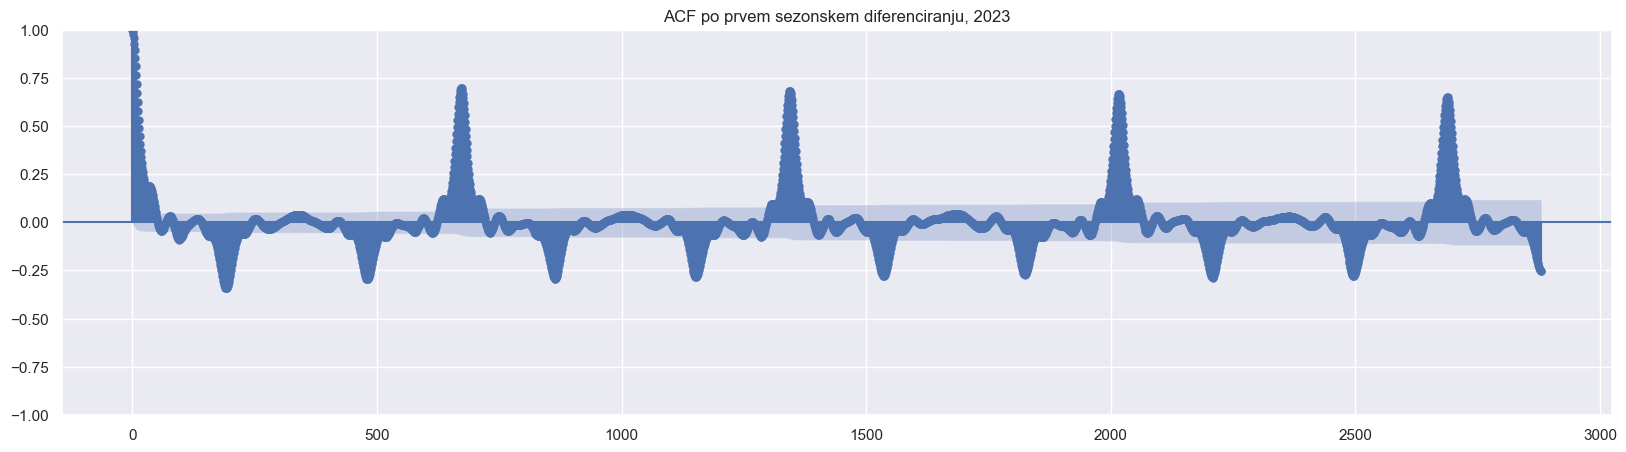

In [8]:
tsaplots.plot_acf(ts_diff['2023'], lags=2880)
plt.ylim(-1,1)
plt.title('ACF po prvem sezonskem diferenciranju, 2023')

In [ ]:
# zgleda stacionarno, ampak diferencirajmo še enkrat

Text(0.5, 1.0, 'Po drugem diferenciranju, 2023')

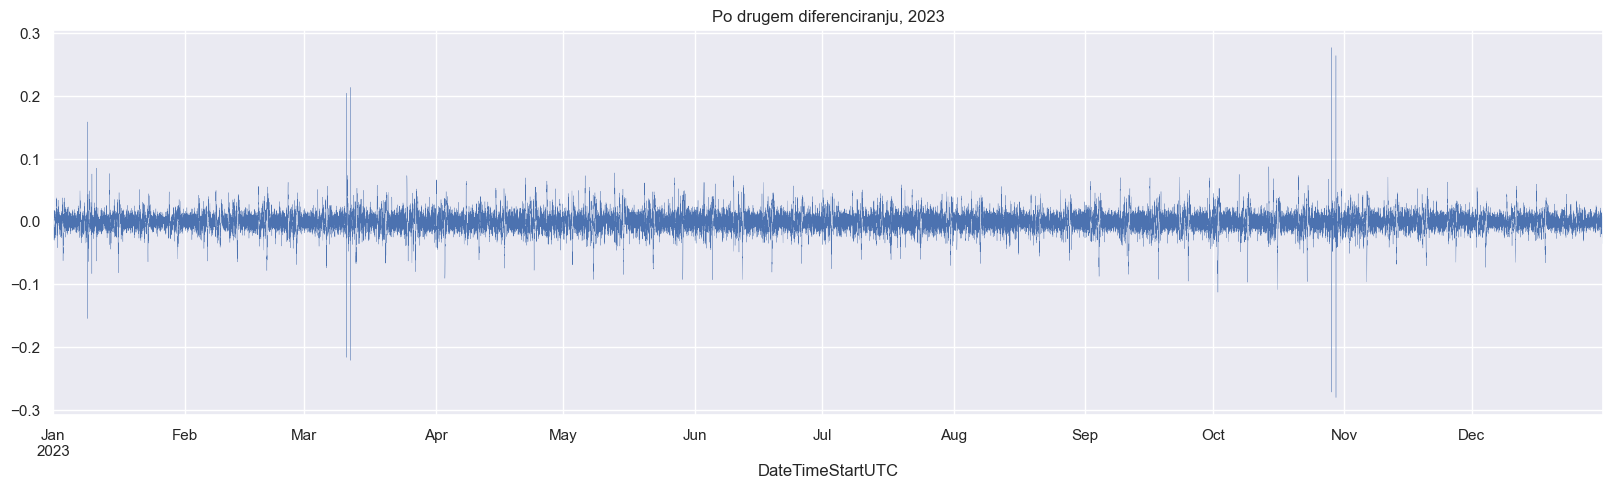

In [12]:
ts_diff2 = ts_diff.diff()
ts_diff2['2023'].plot(linewidth=0.2) 
plt.title('Po drugem diferenciranju, 2023')

Text(0.5, 1.0, 'ACF po drugem diferenciranju, 2023')

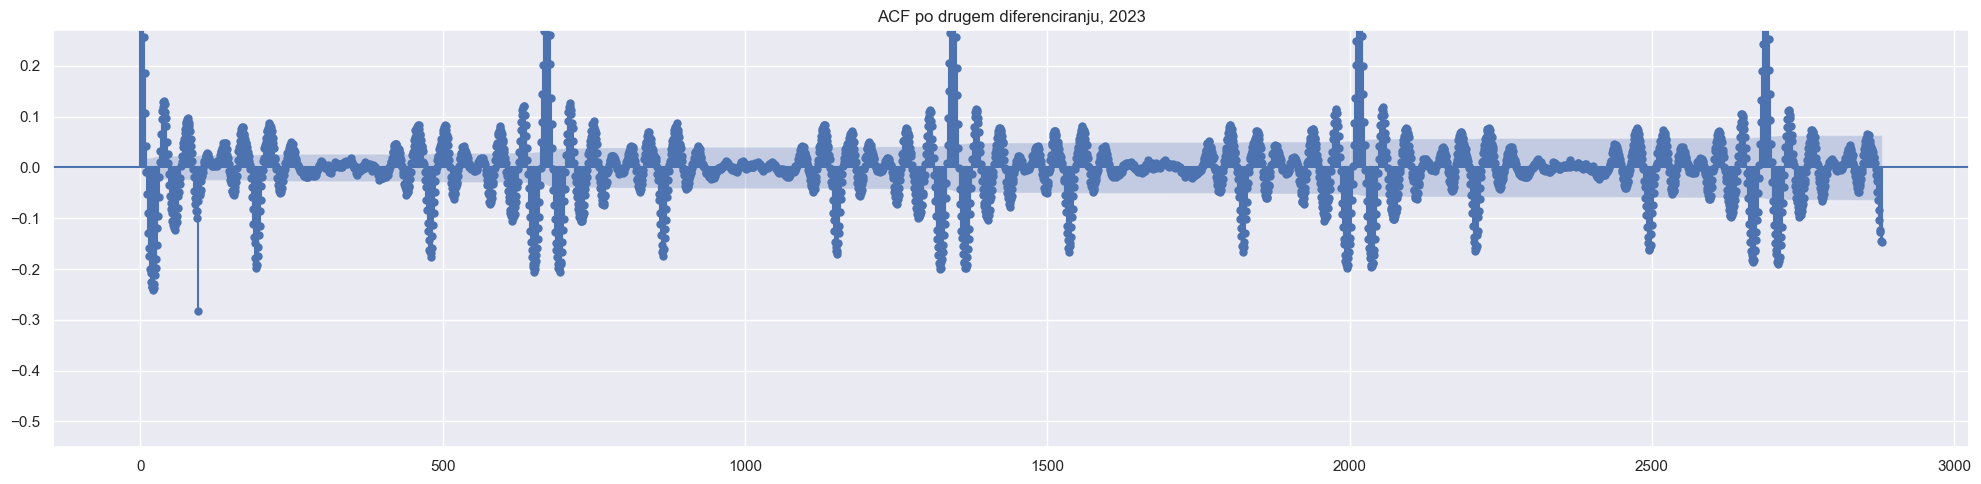

In [82]:
tsaplots.plot_acf(ts_diff2['2023'], lags=2880)
plt.ylim(-0.55,0.27)
plt.tight_layout()
plt.title('ACF po drugem diferenciranju, 2023')

Text(0.5, 1.0, 'Po tretjem diferenciranju, 2023')

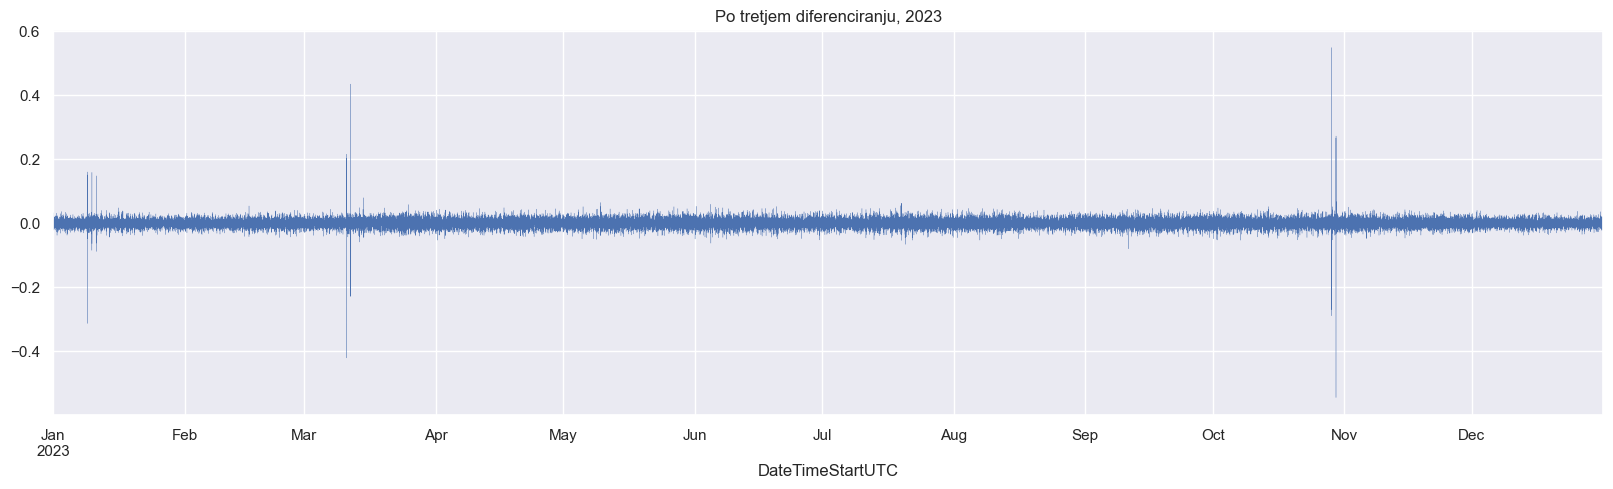

In [13]:
ts_diff3 = ts_diff2.diff()
ts_diff3['2023'].plot(linewidth=0.2) 
plt.title('Po tretjem diferenciranju, 2023')

Text(0.5, 1.0, 'ACF po tretjem diferenciranju, 2023')

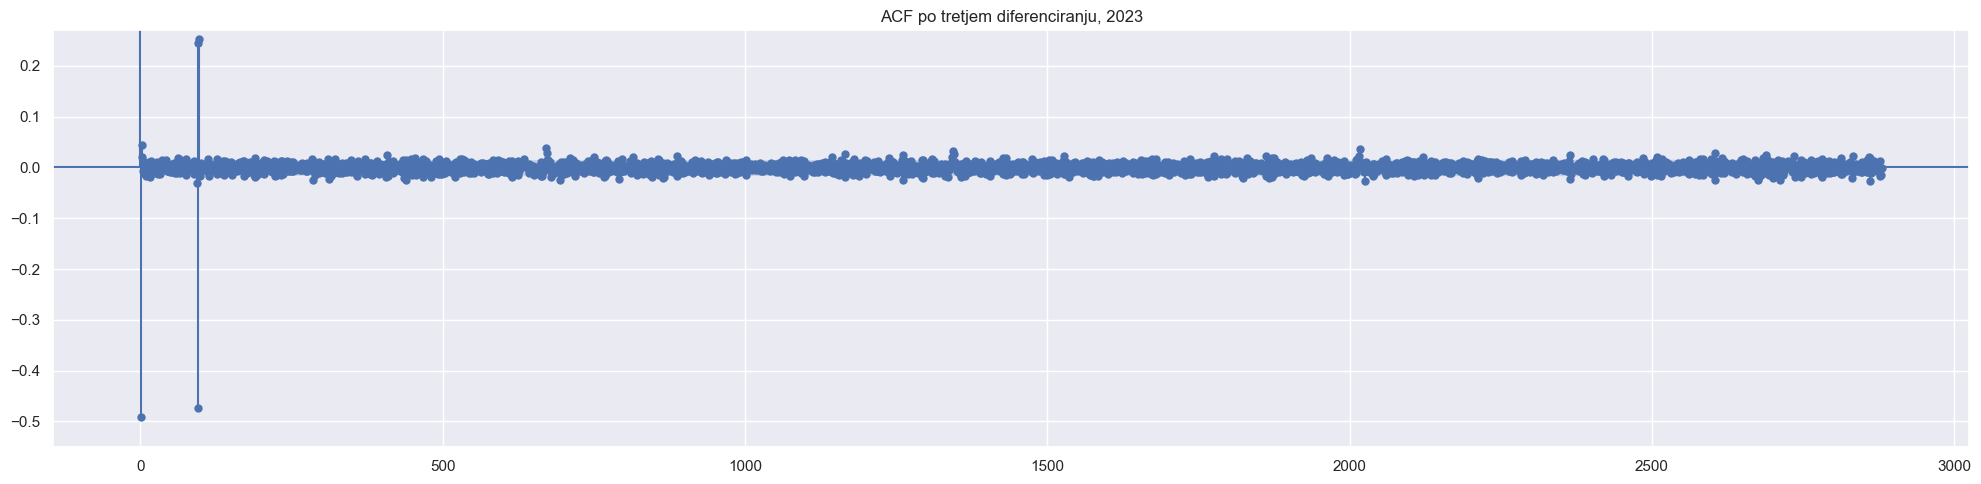

In [85]:
tsaplots.plot_acf(ts_diff3['2023'], lags=2880)
plt.ylim(-0.55,0.27)
plt.tight_layout()
plt.title('ACF po tretjem diferenciranju, 2023')

Text(0.5, 1.0, 'ACF po tretjem diferenciranju, zožen lag, 2023')

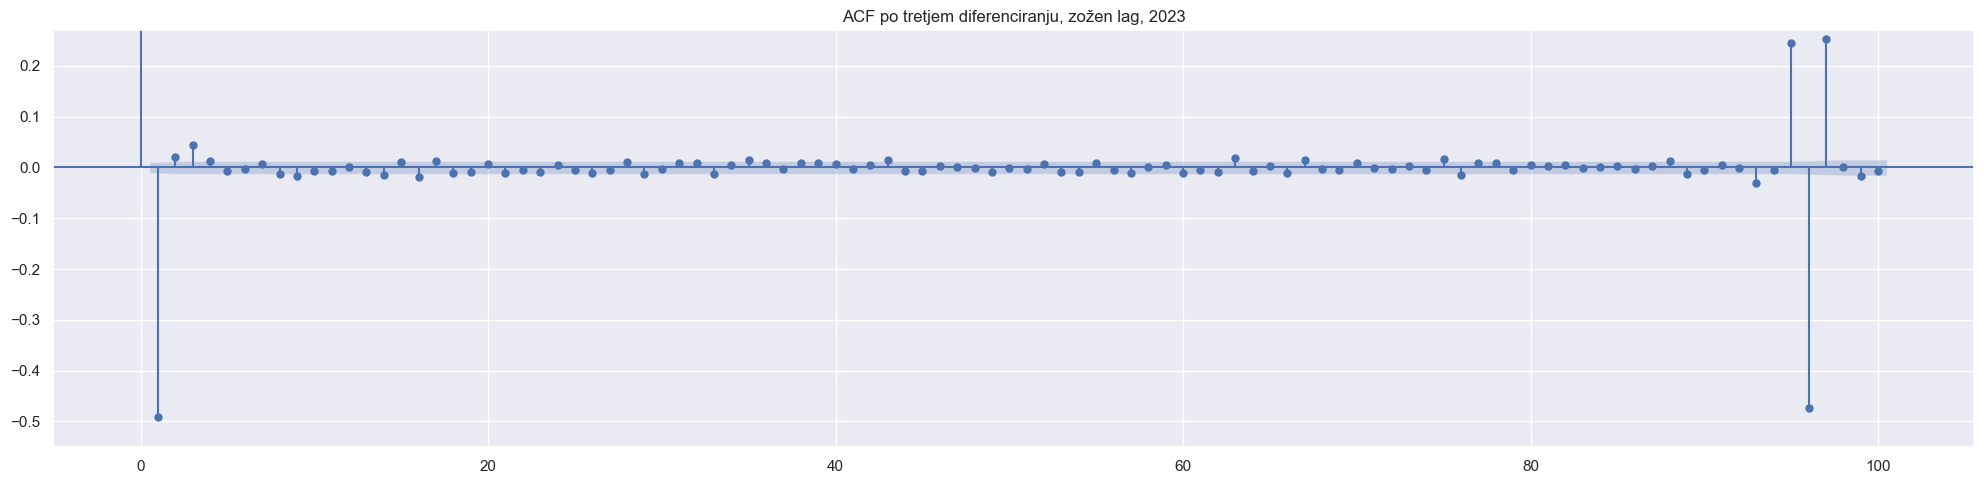

In [86]:
tsaplots.plot_acf(ts_diff3['2023'], lags=100)
plt.ylim(-0.55,0.27)
plt.tight_layout()
plt.title('ACF po tretjem diferenciranju, zožen lag, 2023')

In [87]:
# sedaj zgleda še bolj stacionarno, torej je primerna za model ARMA

# iz ACF se visoko avtokorelacijo opazi pri: 1, 95, 96, 97

# RABIM FORMALNE TESTE?

import statsmodels.tsa.stattools as ts

def test_p_value(data):
        fuller_test = ts.adfuller(data)
        print('P-value: ',fuller_test[1])
        if fuller_test[1] <= 0.05:
            print('Reject null hypothesis, data is stationary')
        else:
            print('Do not reject null hypothesis, data is not stationary')

test_p_value(ts_diff3.dropna())

P-value:  0.0
Reject null hypothesis, data is stationary


Text(0.5, 1.0, 'PACF po tretjem diferenciranju, 2023')

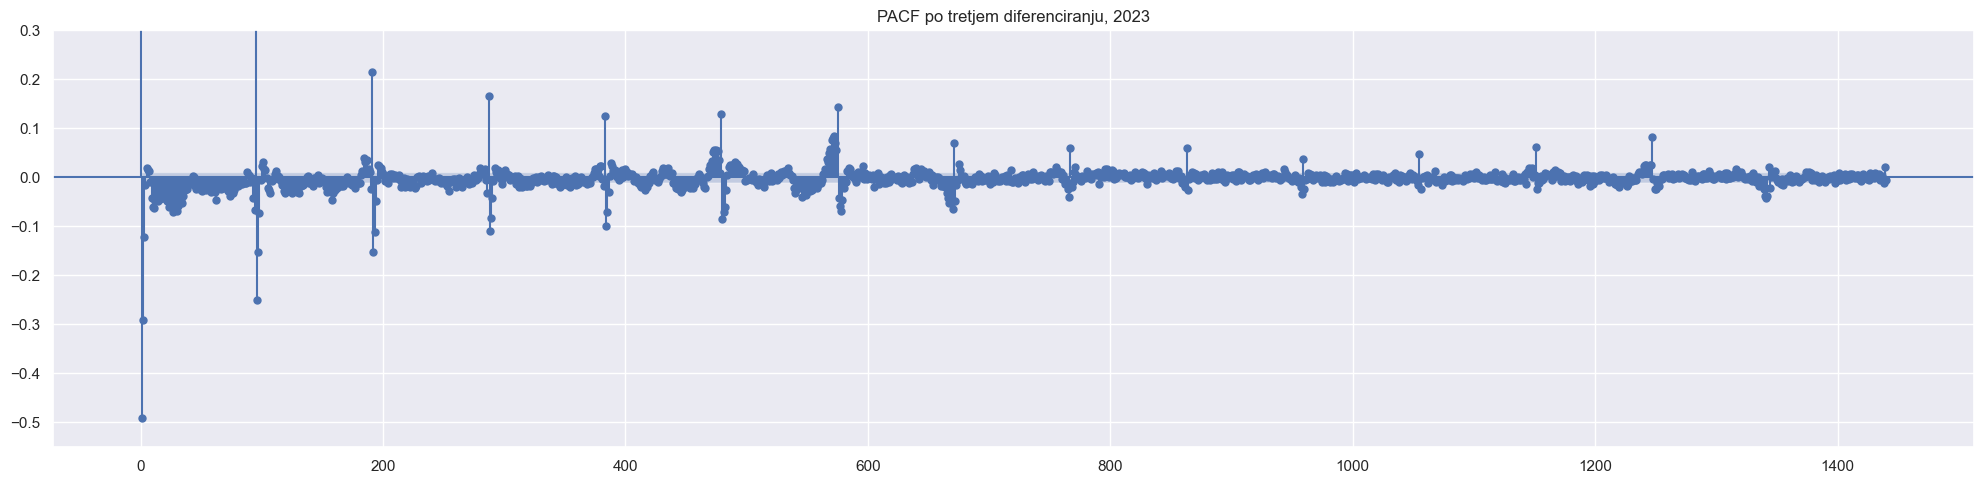

In [90]:
# zaradi izbire modelov si narišemo še PACF

tsaplots.plot_pacf(ts_diff3['2023'].values.squeeze(), lags=1440, method="ywm")
plt.ylim(-0.55,0.30)
plt.tight_layout()
plt.title('PACF po tretjem diferenciranju, 2023')

Text(0.5, 1.0, 'PACF po tretjem diferenciranju, zožen lag, 2023')

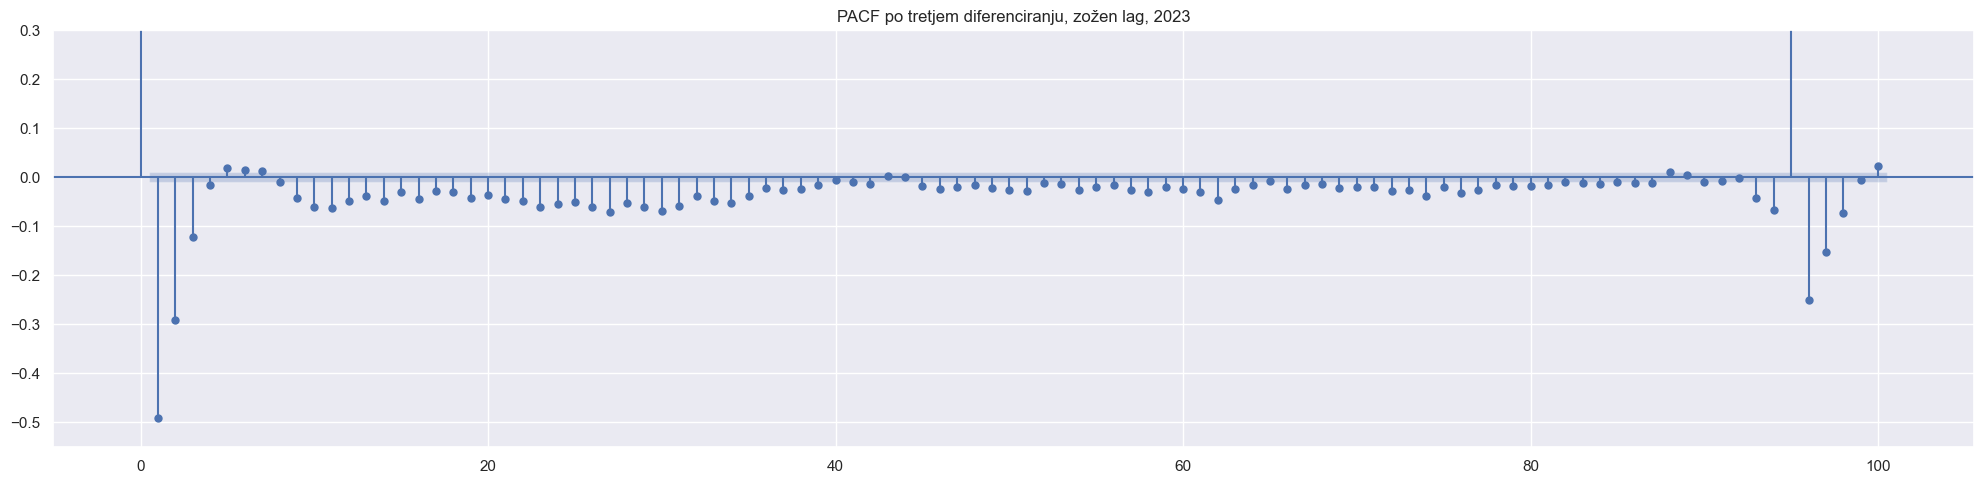

In [23]:
tsaplots.plot_pacf(ts_diff3['2023'].values.squeeze(), lags=100, method="ywm")
plt.ylim(-0.55,0.30)
plt.tight_layout()
plt.title('PACF po tretjem diferenciranju, zožen lag, 2023')

In [ ]:
# visoka korelacije je pri: 1, 2, 3 _____ nato se ponovi pri 95, 191, ... torej se ponovi na 96

# PACF -> AR(p)
# ACF -> MA(q)


# ACF in PACF povesta katere log bi bilo potrebno vključiti
# Zagotovo bomo vključili prvih nekaj meritev/ur, ker imajo večji vpliv
# Koliko dodatnih log-ov bomo še vključili, pa se bomo odločili s pomočjo kriterija AIC

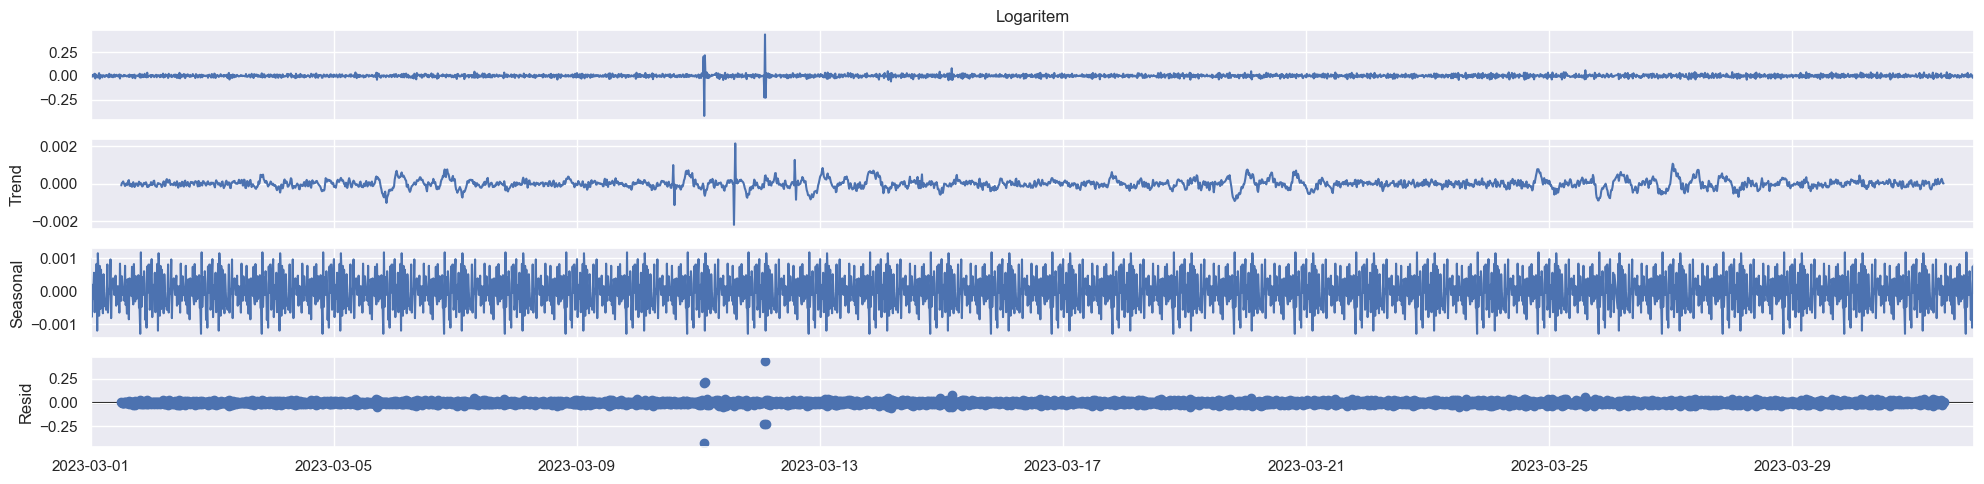

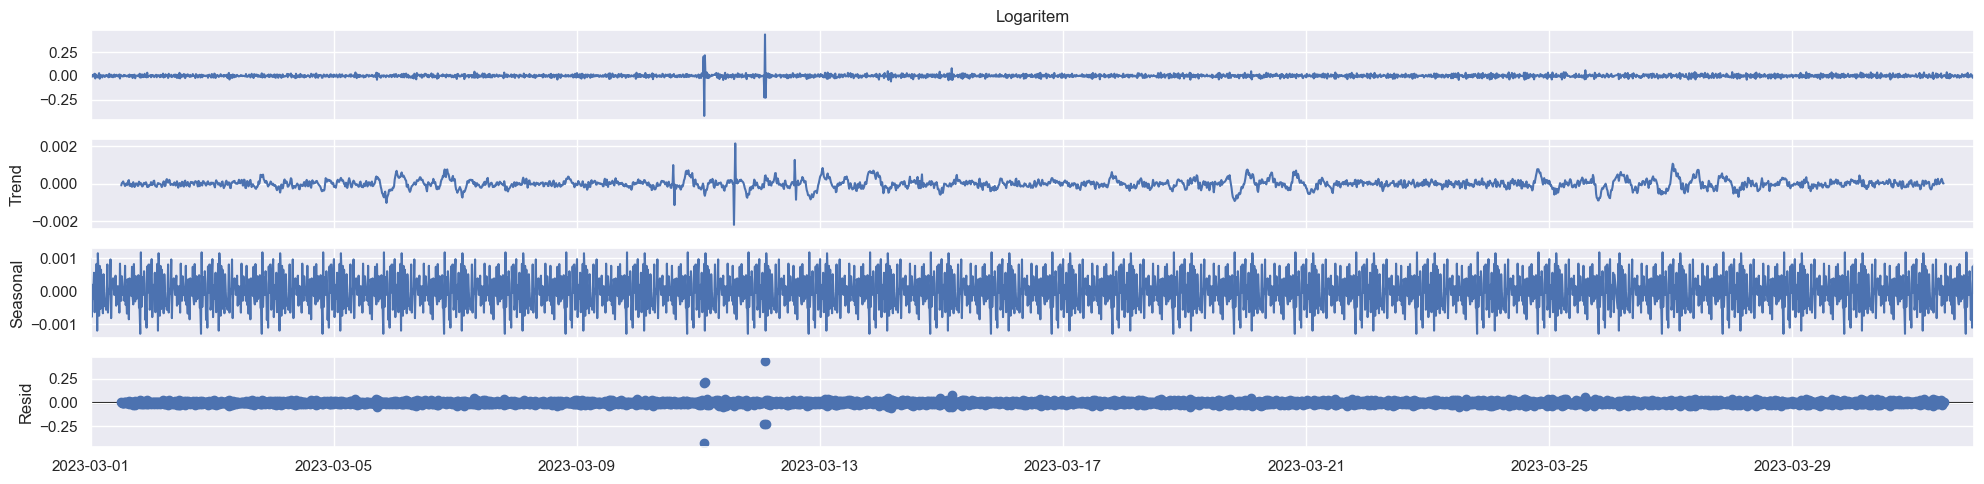

In [93]:
seasonal_decompose(ts_diff3['2023-03'].dropna(), model='additive', period=96).plot()

In [14]:
## MODELI

# da bo šlo bolj hitro se zaenkrat omejimo na samo na dva meseca:
# train data:
train_data = ts_diff3['2023-02-25':'2023-02-28']
train_data_OG = podatki.loc['2023-02-22':'2023-02-28', 'Odjem ACT']
temp_data = podatki.loc['2023-02-22':'2023-02-28', 'Temperatura FC']

# test data:
test_data = ts_diff3['2023-03-01']
test_data_OG = podatki.loc['2023-03-01', 'Odjem ACT']
test_temp_data = podatki.loc['2023-03-01', 'Temperatura FC']

In [ ]:
# uporabljam SARIMA ker imam sezonsko konponento

# !! PRIMERJAVA MED SARIMA in ARIMA !!

In [21]:
model_1 = sm.tsa.statespace.SARIMAX(train_data_OG, order=(1,2,1), seasonal_order=(1,1,1,96))
results_1 = model_1.fit()
results_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Odjem ACT   No. Observations:                  672
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 96)   Log Likelihood               -3692.521
Date:                            Wed, 15 May 2024   AIC                           7395.041
Time:                                    22:30:03   BIC                           7416.805
Sample:                                02-22-2023   HQIC                          7403.530
                                     - 02-28-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0334      0.079      0.421      0.674      -0.122       0.189
ma.L1         -0.4458      0.066     -6.711      0.000      -0.576      -0.316
ar.S.L96       0.0599      0.066      0.911      0.362      -0.069       0.189
ma.S.L96      -0.9990     24.834     -0.040      0.968     -49.673      47.675
sigma2      1.668e+04   4.13e+05      0.040      0.968   -7.93e+05    8.27e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                47.99
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                            -0.19
Prob(H) (two-sided):                  0.24   Kurtosis:                         4.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
model_2 = sm.tsa.statespace.SARIMAX(train_data_OG, order=(1,2,1), seasonal_order=(1,1,0,96))
results_2 = model_2.fit()

In [20]:
model_3 = sm.tsa.statespace.SARIMAX(train_data_OG, order=(3,2,1), seasonal_order=(1,1,0,96))
results_3 = model_3.fit()

In [83]:
model_4 = sm.tsa.statespace.SARIMAX(train_data_OG, order=(3,2,1), seasonal_order=(2,1,1,96))
results_4 = model_4.fit()

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MemoryError: Unable to allocate 441. MiB for an array with shape (293, 293, 673) and data type float64

In [84]:
model_5 = sm.tsa.statespace.SARIMAX(train_data_OG, order=(3,2,1), seasonal_order=(1,1,1,96))
results_5 = model_5.fit()

MemoryError: Unable to allocate 199. MiB for an array with shape (197, 197, 672) and data type float64

In [16]:
model_6 = sm.tsa.statespace.SARIMAX(train_data_OG, order=(0,2,1), seasonal_order=(1,1,1,96))
results_6 = model_6.fit()

In [33]:
model_7 = sm.tsa.statespace.SARIMAX(train_data_OG, order=(0,2,2), seasonal_order=(0,1,1,96))
results_7 = model_7.fit()

MemoryError: Unable to allocate 199. MiB for an array with shape (197, 197, 673) and data type float64

In [22]:

pd.DataFrame([
    ['ARIMA(1,2,1)', 1, 2, 1, 0, 0, 0, 0, sm.tsa.statespace.SARIMAX(train_data_OG, order=(1,2,1)).fit().aic],
    ['ARIMA(3,2,1)', 3, 2, 1, 0, 0, 0, 0, sm.tsa.statespace.SARIMAX(train_data_OG, order=(2,2,1)).fit().aic],
    ['SARIMA(1,2,1)(1,1,0)[96]', 1, 2, 1, 1, 1, 0, 96, results_2.aic], 
    ['SARIMA(1,2,1)(1,1,1)[96]', 1, 2, 1, 1, 1, 1, 96, results_1.aic],
    ['SARIMA(3,2,1)(1,1,0)[96]', 3, 2, 1, 1, 1, 0, 96, results_3.aic],
    ['SARIMA(0,2,1)(1,1,1)[96]', 0, 2, 1, 1, 1, 1, 96, results_6.aic]
],
columns=('Model', 'p', 'd', 'q', 'P', 'D', 'Q', 'S', 'AIC'))

,Model,p,d,q,P,D,Q,S,AIC
0,"ARIMA(1,2,1)",1,2,1,0,0,0,0,8638.425335
1,"ARIMA(3,2,1)",3,2,1,0,0,0,0,8638.217304
2,"SARIMA(1,2,1)(1,1,0)[96]",1,2,1,1,1,0,96,7487.250323
3,"SARIMA(1,2,1)(1,1,1)[96]",1,2,1,1,1,1,96,7395.041474
4,"SARIMA(3,2,1)(1,1,0)[96]",3,2,1,1,1,0,96,7488.873575
5,"SARIMA(0,2,1)(1,1,1)[96]",0,2,1,1,1,1,96,7393.196604


<AxesSubplot: xlabel='DateTimeStartUTC'>

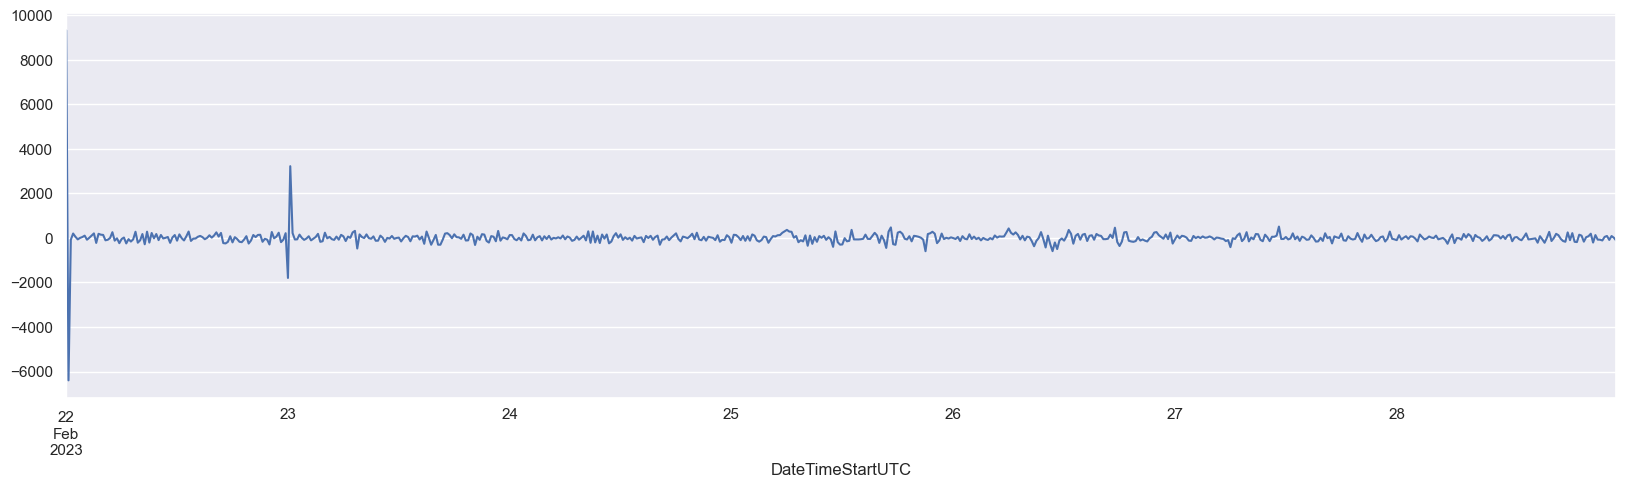

In [23]:
results_6.resid.plot()

Text(0.5, 1.0, 'ACF za SARIMAX')

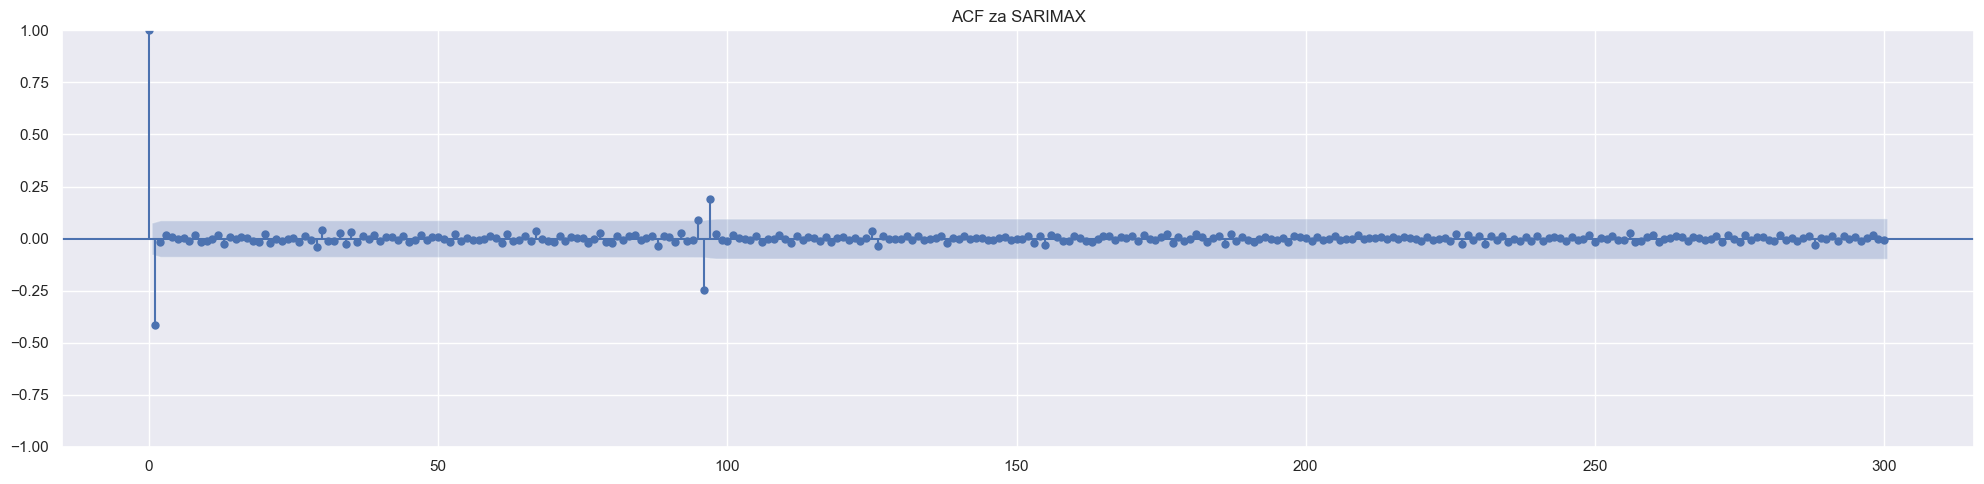

In [24]:
tsaplots.plot_acf(results_6.resid.values.squeeze(), lags=300)
plt.ylim(-1,1)
plt.tight_layout()
plt.title('ACF za SARIMAX')

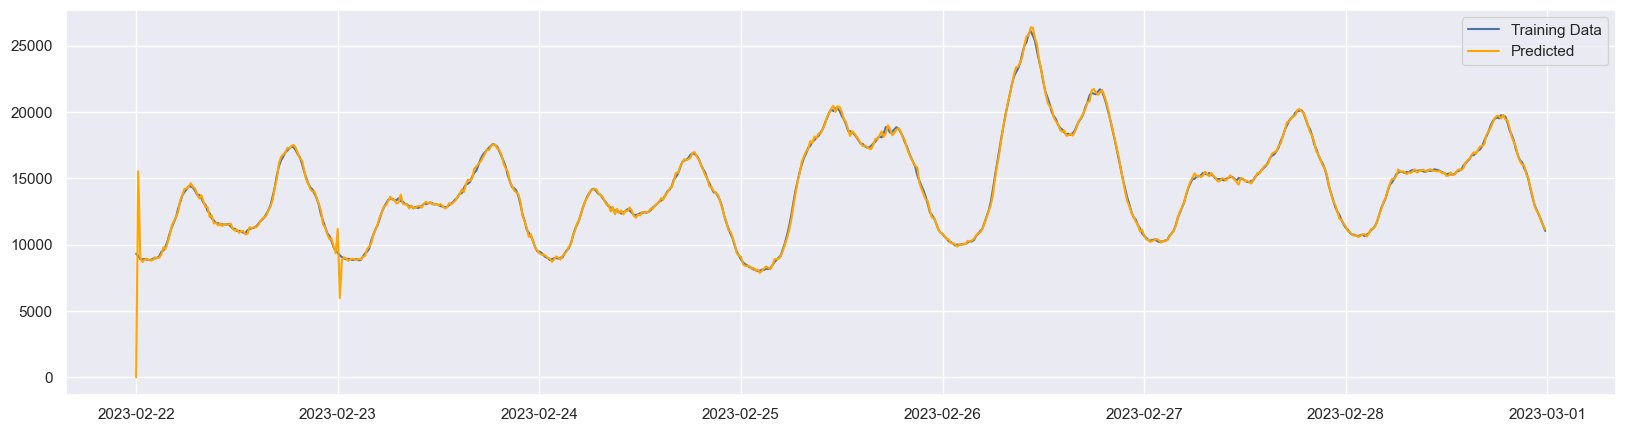

In [25]:
# df['prediction'] = 
results_6.predict()
# >>> df[['Production','prediction']].plot(figsize=(12,8))

plt.plot(train_data_OG, label='Training Data')
plt.plot(results_1.predict(), label='Predicted', color='orange')
plt.legend()

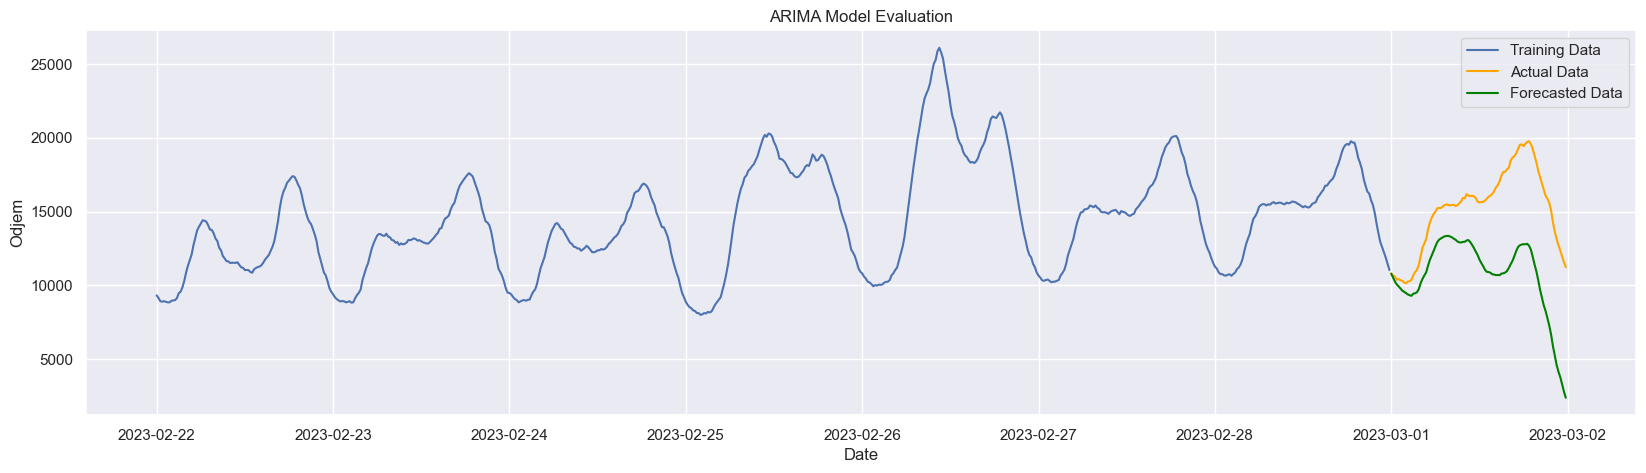

In [26]:
# FORECAST on the test dataset
test_forecast = results_6.get_forecast(steps=96)
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test_data.index)

# narišemo
plt.plot(train_data_OG, label='Training Data')
plt.plot(test_data_OG, label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Odjem')
plt.legend()
plt.show()

In [ ]:



## ==============================================================================================================================================================================================
## ==============================================================================================================================================================================================
## ==============================================================================================================================================================================================
## ==============================================================================================================================================================================================
## ==============================================================================================================================================================================================




In [82]:
## MULTIVARIATE MODEL

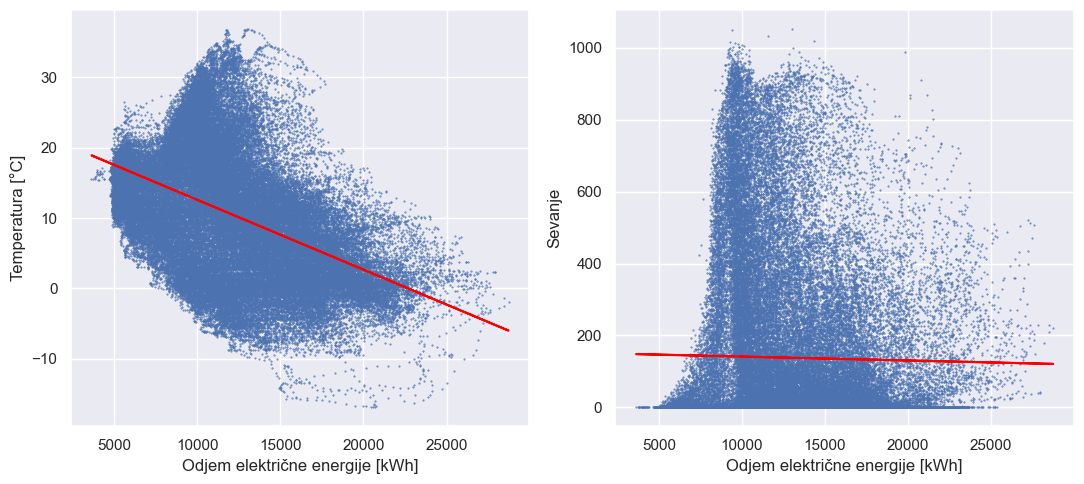

In [27]:
# Povezava med temperaturo in odjemom:

# temperatura
X = np.array(podatki["Odjem ACT"]).reshape(-1, 1)
y = np.array(podatki["Temperatura ACT"])
reg = LinearRegression().fit(X, y)
podatki['predicted'] = reg.predict(X)

# sevanje
X_S = np.array(podatki["Odjem ACT"]).reshape(-1, 1)
y_S = np.array(podatki["Sevanje ACT"])
reg = LinearRegression().fit(X_S, y_S)
podatki['predicted_S'] = reg.predict(X_S)


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(11, 5))

ax1 = plt.subplot(1, 2, 1)
podatki.plot.scatter(x = "Odjem ACT", y = "Temperatura ACT", s = 0.2, ax = ax1, legend=False)
podatki.plot.line(x = "Odjem ACT", y = 'predicted', ax = ax1, color="red", legend=False)
plt.xlabel('Odjem električne energije [kWh]')
plt.ylabel('Temperatura [°C]')

ax1 = plt.subplot(1, 2, 2)
podatki.plot.scatter(x = "Odjem ACT", y = "Sevanje ACT", s = 0.2, ax = ax2, legend=False)
podatki.plot.line(x = "Odjem ACT", y = 'predicted_S', ax = ax2, color="red", legend=False)
plt.xlabel('Odjem električne energije [kWh]')
plt.ylabel('Sevanje')

plt.tight_layout()


In [ ]:
# opazna je povezava --> ?? FORMALNO JE TREBA ŠE PREVERITI KORELIRANOST in te zadevice ??

# sevanja verjetno ne bom uporabljala ??

In [29]:
model_multi = sm.tsa.statespace.SARIMAX(train_data_OG, order=(0,2,1), seasonal_order=(1,1,1,96), exog=temp_data)
results_multi = model_multi.fit()
results_multi.summary()

# fit1= SARIMAX(Train["Monthly_Rate"], order=(1, 0, 1),seasonal_order=(1,1,0,12), exog = sar["Bank Rate Lagged"], 
#              trend='ct', simple_differencing=False,enforce_stationarity=False).fit()
# print(fit1.summary())

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Odjem ACT   No. Observations:                  672
Model:             SARIMAX(0, 2, 1)x(1, 1, 1, 96)   Log Likelihood               -3692.154
Date:                            Wed, 15 May 2024   AIC                           7394.307
Time:                                    22:37:47   BIC                           7416.070
Sample:                                02-22-2023   HQIC                          7402.796
                                     - 02-28-2023                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Temperatura FC   -82.4646     81.385     -1.013      0.311    -241.976      77.047
ma.L1             -0.4220      0.031    -13.813      0.000      -0.482      -0.362
ar.S.L96           0.0605      0.041      1.470      0.142      -0.020       0.141
ma.S.L96          -1.0000      0.051    -19.469      0.000      -1.101      -0.899
sigma2          1.664e+04   3.07e-06   5.43e+09      0.000    1.66e+04    1.66e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                52.84
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                            -0.19
Prob(H) (two-sided):                  0.25   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.02e+30. Standard errors may be unstable.
"""

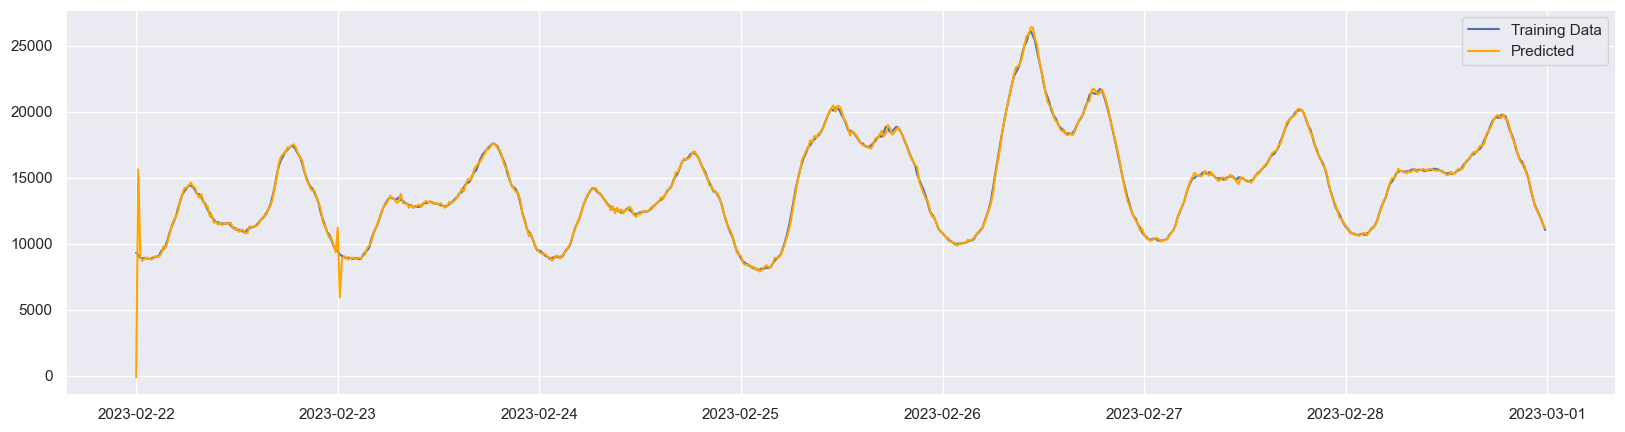

In [30]:
plt.plot(train_data_OG, label='Training Data')
plt.plot(results_multi.predict(exog=temp_data), label='Predicted', color='orange')
plt.legend()

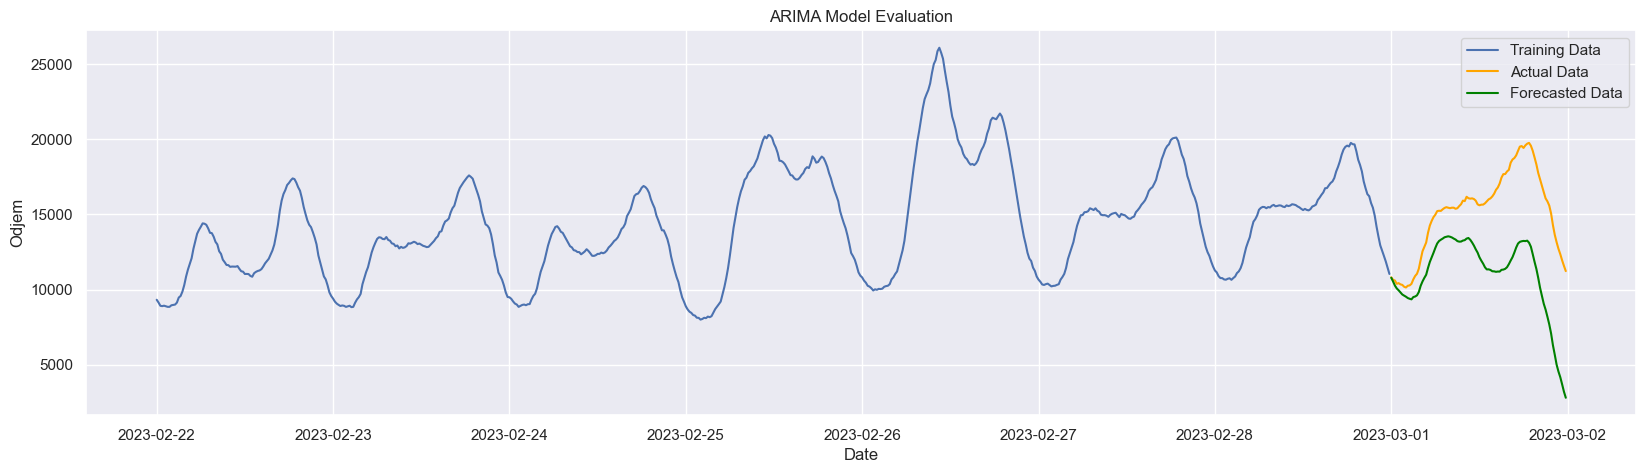

In [31]:
# FORECAST on the test dataset
test_forecast = results_multi.get_forecast(steps=96, exog=test_temp_data)
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test_data.index)

# narišemo
plt.plot(train_data_OG, label='Training Data')
plt.plot(test_data_OG, label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Odjem')
plt.legend()
plt.show()